## Imports

In [39]:
import glob
import itertools
import os
from pprint import pprint
import random
import re
import string
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm import tqdm


%load_ext autoreload
%autoreload 2

import diffexpr


random.seed(2020)

idx = pd.IndexSlice


sc.settings.verbosity = 4
sc.set_figure_params(
    dpi=200, dpi_save=300, transparent=True, vector_friendly=True, frameon=False
)
sc.logging.print_versions()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.4.6.dev9+ge632939 anndata==0.7rc1 umap==0.3.10 numpy==1.17.3 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


[[<matplotlib.axis.XTick at 0x7f55e82a8b70>,
 [Text(0, 0, 'endothelial'),
  Text(0, 0, 'epithelial'),
  Text(0, 0, 'lymphoid'),
  Text(0, 0, 'myeloid'),
  Text(0, 0, 'stromal')]]

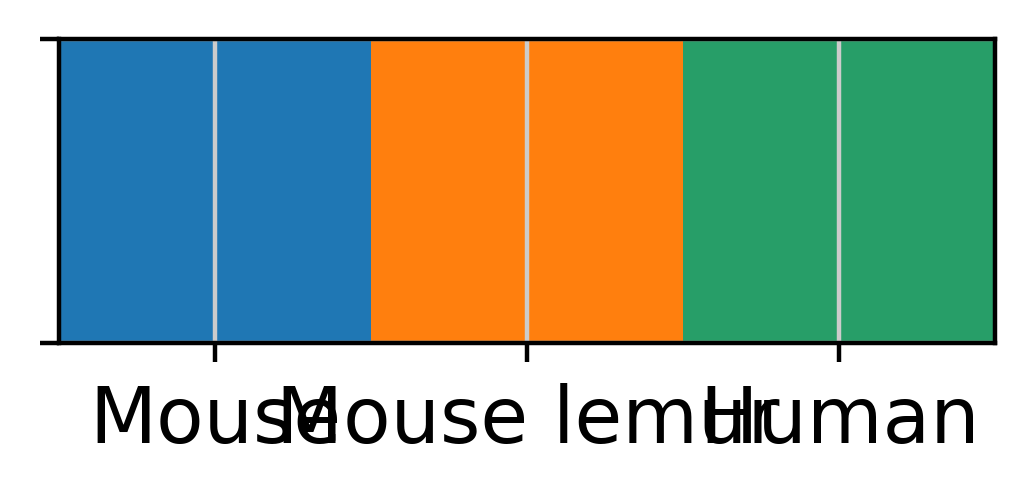

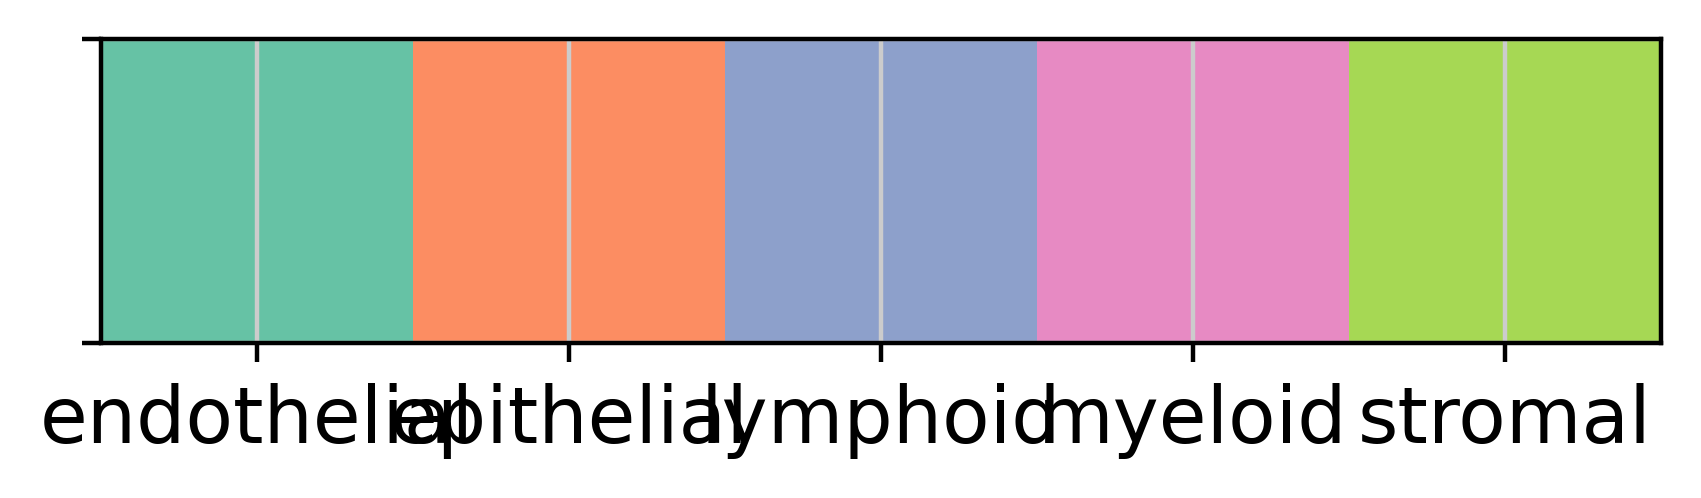

In [4]:
# ---- Set some constants ---
SPECIES_ORDER = ["Mouse", "Mouse lemur", "Human"]
SPECIES_BATCH_ORDER = ["mouse", "lemur", "human"]
N_SPECIES = len(SPECIES_ORDER)
SPECIES_PALETTE = sns.color_palette(n_colors=N_SPECIES)
sns.palplot(SPECIES_PALETTE)
ax = plt.gca()
ax.set(xticklabels=SPECIES_ORDER, xticks=np.arange(N_SPECIES))
SPECIES_BATCH_TO_COLOR_MAP = {"mouse": "Blues", "lemur": "YlOrBr", "human": "Greens"}
SPECIES_TO_COLOR_MAP = {"Mouse": "Blues", "Mouse lemur": "YlOrBr", "Human": "Greens"}


compartments = ["endothelial", "epithelial", "lymphoid", "myeloid", "stromal"]
n_compartments = len(compartments)
compartment_colors = sns.color_palette("Set2", n_colors=n_compartments)
sns.palplot(compartment_colors)
compartment_to_color = dict(zip(compartments, compartment_colors))
ax = plt.gca()
ax.set(xticklabels=compartments, xticks=np.arange(n_compartments))

In [5]:
h5ad = '/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species/concatenated__human-lung--lemur-lung--mouse-lung__10x__one2one_orthologs__unified_compartments__bbknn.h5ad'
adata = sc.read_h5ad(h5ad)

In [ ]:
adata.groupby('')

# Get disease-relevant genes

## Get lung disease genes

In [97]:
import json

with open('lung_related_disease_genes.json') as f:
    lung_disease_genes = json.load(f)
lung_disease_genes_many_genes = {k: v for k, v in lung_disease_genes.items() if len(v) > 10}
lung_disease_genes_few_genes = {k: v for k, v in lung_disease_genes.items() if len(v) <= 10}
lung_disease_genes_remaining_genes = list(set(itertools.chain(*[v for k, v in lung_disease_genes_few_genes.items()])))
len(lung_disease_genes_remaining_genes)

132

In [98]:
len(lung_disease_genes_many_genes)

10

## Get ligand-receptor pairs

In [6]:
receptor_ligand_pairs = pd.read_csv('https://raw.githubusercontent.com/krasnowlab/HLCA/master/Analysis/dbs/PairsLigRec.txt', 
                                    sep='\t', index_col=0)
print(receptor_ligand_pairs.shape)
receptor_ligand_pairs.head() 

## Filter by ligands and receptors actually present in the data

ligand_col = 'Ligand.ApprovedSymbol'
receptor_col = 'Receptor.ApprovedSymbol'

ligand_present = receptor_ligand_pairs[ligand_col].isin(adata.var.index)
receptor_present = receptor_ligand_pairs[receptor_col].isin(adata.var.index)

receptor_ligand_pairs_present = receptor_ligand_pairs.loc[ligand_present & receptor_present]
print(receptor_ligand_pairs_present.shape)
receptor_ligand_pairs_present.head()

(2557, 15)
(1572, 15)


,Ligand.ApprovedSymbol,Ligand.Name,Receptor.ApprovedSymbol,Receptor.Name,DLRP,HPMR,IUPHAR,HPRD,STRING.binding,STRING.experiment,HPMR.Ligand,HPMR.Receptor,PMID.Manual,Pair.Source,Pair.Evidence
Pair.Name,,,,,,,,,,,,,,,
A2M_LRP1,A2M,alpha-2-macroglobulin,LRP1,low density lipoprotein receptor-related prote...,NaN,HPMR,NaN,HPRD,STRING.binding,STRING.experiment,A2M,LRP1,NaN,known,literature supported
ACE_AGTR2,ACE,angiotensin I converting enzyme,AGTR2,"angiotensin II receptor, type 2",NaN,NaN,NaN,HPRD,NaN,NaN,ACE,AGTR2,NaN,novel,literature supported
ACE_BDKRB2,ACE,angiotensin I converting enzyme,BDKRB2,bradykinin receptor B2,NaN,NaN,NaN,HPRD,NaN,NaN,ACE,BDKRB2,NaN,novel,literature supported
ADAM10_AXL,ADAM10,ADAM metallopeptidase domain 10,AXL,AXL receptor tyrosine kinase,NaN,NaN,NaN,HPRD,NaN,NaN,ADAM10,AXL,NaN,novel,literature supported
ADAM10_EPHA3,ADAM10,ADAM metallopeptidase domain 10,EPHA3,EPH receptor A3,NaN,NaN,NaN,HPRD,NaN,STRING.experiment,ADAM10,EPHA3,NaN,novel,literature supported


# Parse differential expression data

In [7]:
de_base = '/home/olga/googledrive/TabulaMicrocebus/analysis/cross-species-lung/across-species-within-group-diffexpr/'

In [16]:
def read_de_result(filename, result_type):
    basename = os.path.basename(filename)
    dirname = os.path.dirname(filename)
    parent_folder = dirname.split(os.pathsep)[-1]
    reference = parent_folder.split('__')[-1].split('vs-')[-1]
    
    prefix = basename.split('.csv')[0]
    split = prefix.split('__')
    celltype = split[-2]
    
    df = pd.read_csv(filename, index_col=0)
    # Rename full species name to shorthand name
    df = df.rename(columns={'Mouse': 'mouse', "Human": 'human', "Mouse lemur": "lemur"})
    df = df.stack().to_frame()
    df['celltype'] = celltype
    df['reference'] = reference
    df = df.rename(columns={0: result_type})
    return df



score_dfs = [read_de_result(f, 'score') for f in tqdm(sorted(glob.iglob(f"{de_base}/*/*scores.csv")))]
name_dfs = [read_de_result(f, 'gene_name') for f in tqdm(sorted(glob.iglob(f"{de_base}/*/*names.csv")))]

100%|██████████| 42/42 [00:17<00:00,  2.35it/s]


In [17]:
scores = pd.concat(score_dfs)
print(scores.shape)
scores.head()

(126000, 3)


score                celltype reference
0 mouse  0.020239  adventitial_fibroblast     human
  lemur  0.015384  adventitial_fibroblast     human
  human  0.016735  adventitial_fibroblast     human
1 mouse  0.011801  adventitial_fibroblast     human
  lemur  0.014881  adventitial_fibroblast     human

In [54]:
names = pd.concat(name_dfs)
print(names.shape)
names.head()

(126000, 3)


gene_name                celltype reference
0 mouse       GSN  adventitial_fibroblast     human
  lemur      APOE  adventitial_fibroblast     human
  human       CFD  adventitial_fibroblast     human
1 mouse    CLEC3B  adventitial_fibroblast     human
  lemur       DCN  adventitial_fibroblast     human

In [55]:
# only use the "score" column of the score dataframe
de_scores_names = pd.concat([scores['score'], names], axis=1)
de_scores_names = de_scores_names.reset_index()
de_scores_names = de_scores_names.rename(columns={'level_0': 'de_rank', 'level_1': 'query_species'})
print(de_scores_names.shape)
de_scores_names.head()

(126000, 6)


,de_rank,query_species,score,gene_name,celltype,reference
0,0,mouse,0.020239,GSN,adventitial_fibroblast,human
1,0,lemur,0.015384,APOE,adventitial_fibroblast,human
2,0,human,0.016735,CFD,adventitial_fibroblast,human
3,1,mouse,0.011801,CLEC3B,adventitial_fibroblast,human
4,1,lemur,0.014881,DCN,adventitial_fibroblast,human


In [56]:
de_scores_names['score_log10'] = np.log10(de_scores_names['score'])
de_scores_names.head()

,de_rank,query_species,score,gene_name,celltype,reference,score_log10
0,0,mouse,0.020239,GSN,adventitial_fibroblast,human,-1.693815
1,0,lemur,0.015384,APOE,adventitial_fibroblast,human,-1.812931
2,0,human,0.016735,CFD,adventitial_fibroblast,human,-1.776368
3,1,mouse,0.011801,CLEC3B,adventitial_fibroblast,human,-1.928099
4,1,lemur,0.014881,DCN,adventitial_fibroblast,human,-1.827379


In [57]:
de_scores_names.query('gene_name == "HHIP"')

,de_rank,query_species,score,gene_name,celltype,reference,score_log10
1318,439,lemur,0.000303,HHIP,adventitial_fibroblast,human,-3.518242
3826,275,lemur,0.000182,HHIP,alveolar_epithelial_type_2,human,-3.740911
4283,427,human,0.000108,HHIP,alveolar_epithelial_type_2,human,-3.966756
7545,515,mouse,0.000219,HHIP,alveolar_fibroblast,human,-3.660091
43339,446,lemur,0.000297,HHIP,adventitial_fibroblast,lemur,-3.527806
45811,270,lemur,0.000182,HHIP,alveolar_epithelial_type_2,lemur,-3.739776
46268,422,human,0.000109,HHIP,alveolar_epithelial_type_2,lemur,-3.962275
49329,443,mouse,0.000254,HHIP,alveolar_fibroblast,lemur,-3.594695
85384,461,lemur,0.000290,HHIP,adventitial_fibroblast,mouse,-3.537832
87817,272,lemur,0.000182,HHIP,alveolar_epithelial_type_2,mouse,-3.739412


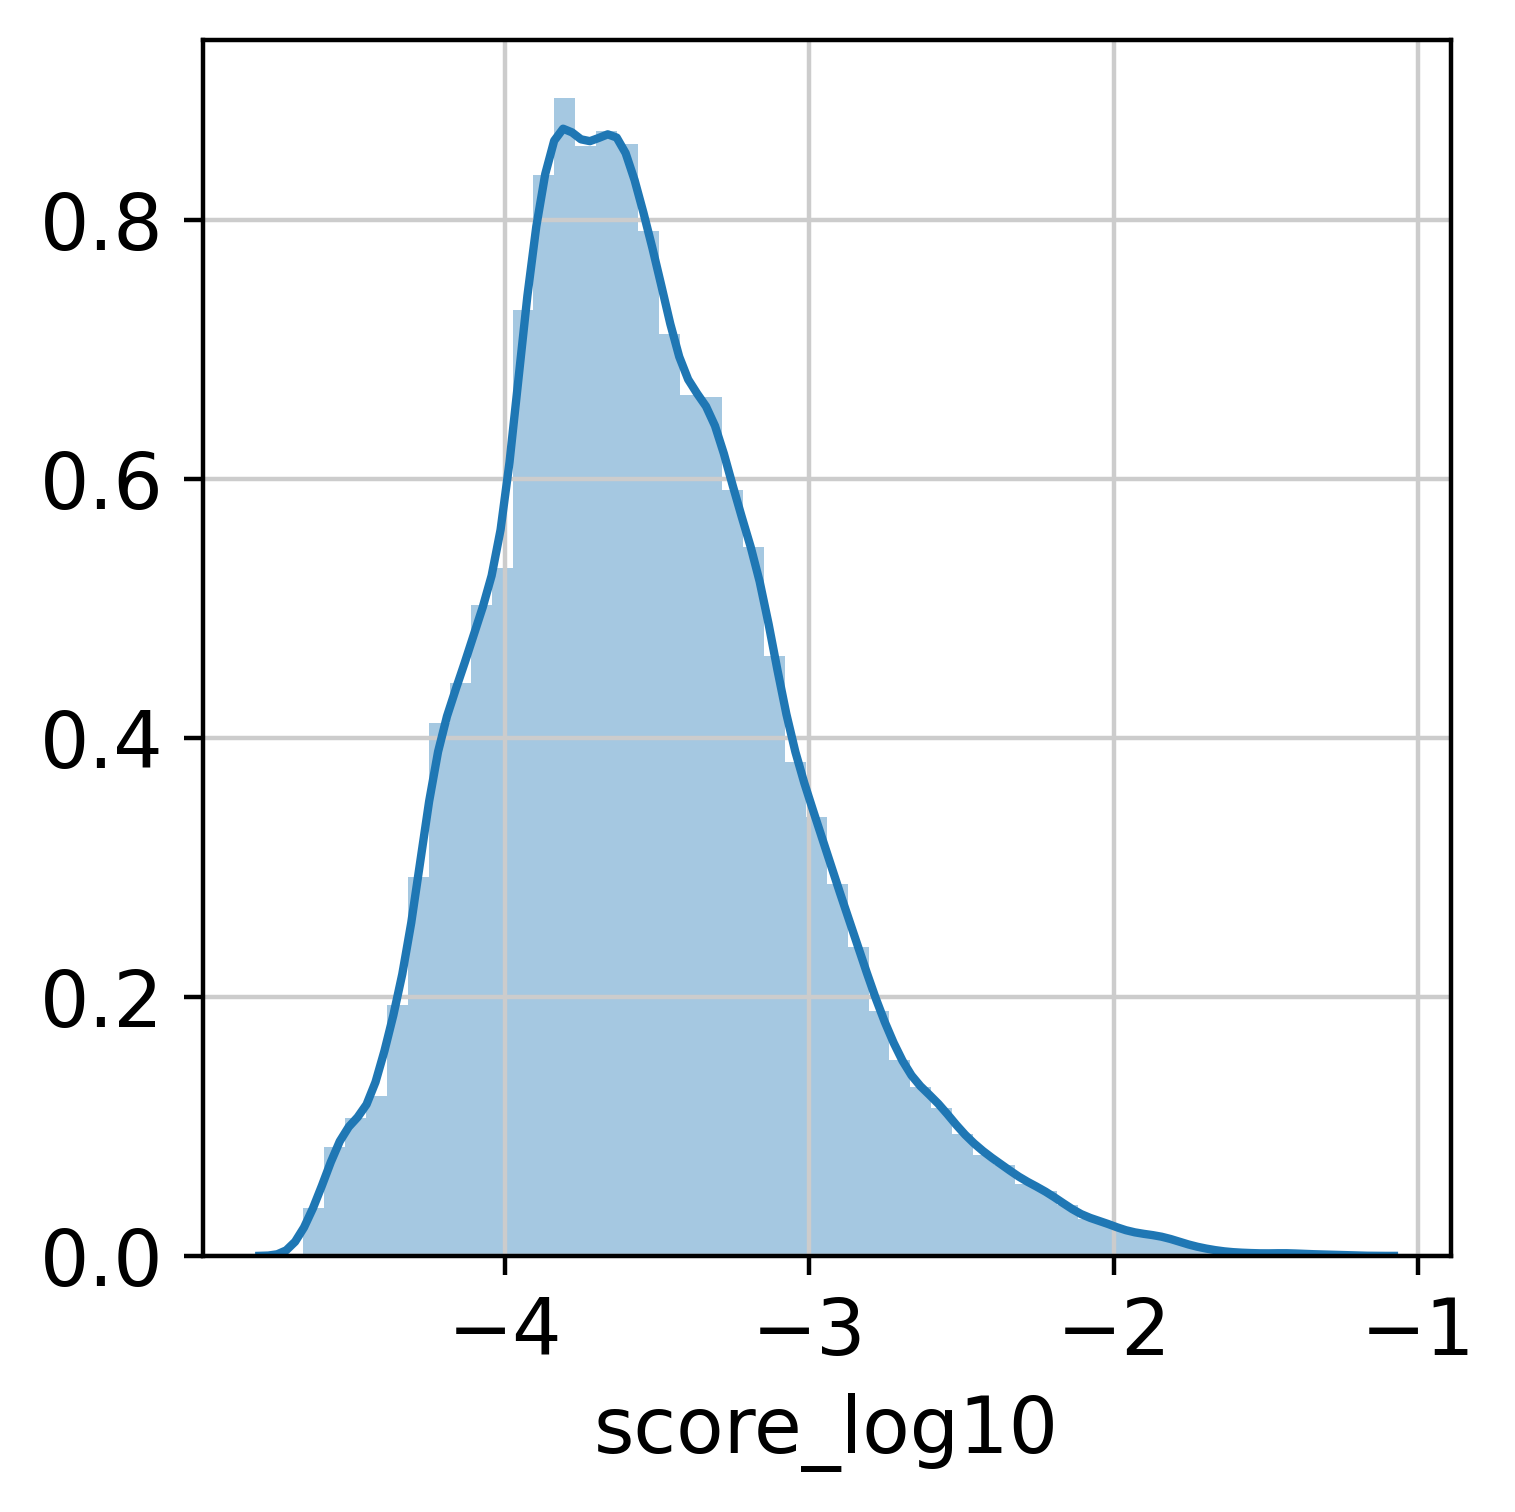

In [58]:
sns.distplot(de_scores_names.score_log10)

In [31]:
de_scores_names.gene_name.nunique()

7990

## REmove technical artifact genes

### artifact_genes.txt

In [36]:
%%file artifact_genes.txt
ATF3
BTG2
CEBPB
CEBPD
DNAJA1
DNAJB1
DUSP1
EGR1
FOS
FOSB
HBA1
HBB
HSP90AA1
HSP90AB1
HSPA8
HSPB1
HSPE1
HSPH1
ID3
IER2
JUN
JUNB
JUND
NFKBIA
NR4A1
PPP1R15A
RP[LS]\d+[A-Z]?
SOCS3
TMSB4X
ZFP36


Writing artifact_genes.txt


### Technical artifact genes removing function

In [42]:

def parse_artifact_genes(artifact_genes_txt):
    # RP[LS]\d+[A-Z]? FOS JUNB TMSB4X HBA1 HBB
    # Open the json file containing the list of strings that represent
    # the technical artifact genes to remove
    with open(artifact_genes_txt, "r") as f:
        genes_to_remove = [x.strip() for x in f.readlines()]
    regex_genes = []
    non_regex_genes = []
    # Extract genes containing ?[ etc as regex genes
    # and only alphabets as non-regex genes
    for gene in genes_to_remove:
        if gene.isalnum():
            non_regex_genes.append(gene)
        else:
            regex_genes.append(gene)
    return non_regex_genes, regex_genes

ARTIFACT_REGEX, ARTIFACT_NAMES = parse_artifact_genes('artifact_genes.txt')


def is_technical_artifact_gene_names(column, regex_genes=ARTIFACT_NAMES, non_regex_genes=ARTIFACT_REGEX):
    """Return a boolean of whether the column contains technical artifact genes"""
    # Remove the rows in the dataframe containing human gene that matches the regex
    is_artifact = pd.Series(False, index=column.index)
    
    for regex_gene in regex_genes:
        is_artifact = column.str.contains(regex_gene, flags=re.IGNORECASE, regex=True)
        
    # Keep rows in the dataframe that contain human gene names that
    # do not match with the list of non regex genes
    is_artifact = column.isin(non_regex_genes)
    return is_artifact



In [44]:
rows = is_technical_artifact_gene_names(de_scores_names.gene_name)
print(rows.sum())
de_scores_names_no_artifacts = de_scores_names.loc[~rows]
print(de_scores_names_no_artifacts.shape)
de_scores_names_no_artifacts.head()

924
(125076, 6)


,de_rank,query_species,score,gene_name,celltype,reference
0,0,mouse,0.020239,GSN,adventitial_fibroblast,human
1,0,lemur,0.015384,APOE,adventitial_fibroblast,human
2,0,human,0.016735,CFD,adventitial_fibroblast,human
3,1,mouse,0.011801,CLEC3B,adventitial_fibroblast,human
4,1,lemur,0.014881,DCN,adventitial_fibroblast,human


## Get genes higher in primates, relative to mouse

In [59]:
de_scores_names_ref_mouse = de_scores_names_no_artifacts.query('(reference == "mouse") and (score > 1e-4)')
print(de_scores_names_ref_mouse.shape)
de_scores_names_ref_mouse.head()

(34514, 6)


,de_rank,query_species,score,gene_name,celltype,reference
84000,0,mouse,0.020323,GSN,adventitial_fibroblast,mouse
84001,0,lemur,0.015506,APOE,adventitial_fibroblast,mouse
84002,0,human,0.016908,CFD,adventitial_fibroblast,mouse
84003,1,mouse,0.011760,CLEC3B,adventitial_fibroblast,mouse
84004,1,lemur,0.014845,DCN,adventitial_fibroblast,mouse


In [69]:
dfs = []

for celltype, df in de_scores_names_ref_mouse.groupby('celltype'):
    print(f'--- {celltype} ---')
    mouse = df.query('query_species == "mouse"')
    primates = df.query('query_species != "mouse"')
    rows = ~primates.gene_name.isin(mouse.gene_name)
    print(rows.sum())
    df2 = primates.loc[rows]
    dfs.append(df)
primate_enriched = pd.concat(dfs, ignore_index=True)
print(primate_enriched.shape)
primate_enriched.head()

--- adventitial_fibroblast ---
1567
--- alveolar_epithelial_type_2 ---
863
--- alveolar_fibroblast ---
1818
--- capillary ---
1877
--- capillary_aerocyte ---
1249
--- cd4+_t ---
1393
--- lymphatic ---
1861
--- macrophage ---
1395
--- monocyte ---
1387
--- myeloid_dendritic ---
1410
--- natural_killer ---
1808
--- plasma ---
737
--- proliferating_macrophage ---
808
--- proliferating_nk-slash-t ---
1699
(34514, 6)


,de_rank,query_species,score,gene_name,celltype,reference
0,0,mouse,0.020323,GSN,adventitial_fibroblast,mouse
1,0,lemur,0.015506,APOE,adventitial_fibroblast,mouse
2,0,human,0.016908,CFD,adventitial_fibroblast,mouse
3,1,mouse,0.011760,CLEC3B,adventitial_fibroblast,mouse
4,1,lemur,0.014845,DCN,adventitial_fibroblast,mouse


# Look at gene subsets

## Ligands

In [24]:
ligand_rows = de_scores_names['gene_name'].isin(receptor_ligand_pairs_present[ligand_col])
de_scores_names_ligands = de_scores_names.loc[ligand_rows]
print(de_scores_names_ligands.shape)
de_scores_names_ligands.head()

(4740, 6)


,de_rank,query,score,gene_name,celltype,reference
1,0,lemur,0.015384,APOE,adventitial_fibroblast,human
4,1,lemur,0.014881,DCN,adventitial_fibroblast,human
5,1,human,0.016074,FBLN1,adventitial_fibroblast,human
9,3,mouse,0.009271,COL3A1,adventitial_fibroblast,human
11,3,human,0.008589,A2M,adventitial_fibroblast,human


In [25]:
receptor_rows = de_scores_names['gene_name'].isin(receptor_ligand_pairs_present[receptor_col])
de_scores_names_receptors = de_scores_names.loc[receptor_rows]
print(de_scores_names_receptors.shape)
de_scores_names_receptors.head()

(4305, 6)


,de_rank,query,score,gene_name,celltype,reference
63,21,mouse,0.003344,CD81,adventitial_fibroblast,human
79,26,lemur,0.002918,CD74,adventitial_fibroblast,human
104,34,human,0.002608,CD63,adventitial_fibroblast,human
162,54,mouse,0.001333,PDGFRA,adventitial_fibroblast,human
203,67,human,0.001491,CAV1,adventitial_fibroblast,human


In [71]:
receptor_ligand_pairs.shape

(2557, 15)

In [70]:
def filter_receptor_ligand_pairs(receptor_ligand_pairs, gene_names):
    receptor_de = receptor_ligand_pairs_present[receptor_col].isin(gene_names)
    ligand_de = receptor_ligand_pairs_present[ligand_col].isin(gene_names)
    df = receptor_ligand_pairs_present.loc[receptor_de | ligand_de]
    return df
    
receptor_ligand_pairs_primate = filter_receptor_ligand_pairs(receptor_ligand_pairs, primate_enriched.gene_name)
print(receptor_ligand_pairs_primate.shape)
receptor_ligand_pairs_primate.head()

(1380, 15)


,Ligand.ApprovedSymbol,Ligand.Name,Receptor.ApprovedSymbol,Receptor.Name,DLRP,HPMR,IUPHAR,HPRD,STRING.binding,STRING.experiment,HPMR.Ligand,HPMR.Receptor,PMID.Manual,Pair.Source,Pair.Evidence
Pair.Name,,,,,,,,,,,,,,,
A2M_LRP1,A2M,alpha-2-macroglobulin,LRP1,low density lipoprotein receptor-related prote...,NaN,HPMR,NaN,HPRD,STRING.binding,STRING.experiment,A2M,LRP1,NaN,known,literature supported
ACE_AGTR2,ACE,angiotensin I converting enzyme,AGTR2,"angiotensin II receptor, type 2",NaN,NaN,NaN,HPRD,NaN,NaN,ACE,AGTR2,NaN,novel,literature supported
ACE_BDKRB2,ACE,angiotensin I converting enzyme,BDKRB2,bradykinin receptor B2,NaN,NaN,NaN,HPRD,NaN,NaN,ACE,BDKRB2,NaN,novel,literature supported
ADAM10_AXL,ADAM10,ADAM metallopeptidase domain 10,AXL,AXL receptor tyrosine kinase,NaN,NaN,NaN,HPRD,NaN,NaN,ADAM10,AXL,NaN,novel,literature supported
ADAM10_EPHA3,ADAM10,ADAM metallopeptidase domain 10,EPHA3,EPH receptor A3,NaN,NaN,NaN,HPRD,NaN,STRING.experiment,ADAM10,EPHA3,NaN,novel,literature supported


In [79]:
def get_ligand_receptor_groups(receptor_ligand, ligand, verbose=False):
    ligand_df = receptor_ligand.loc[receptor_ligand[ligand_col] == ligand]

    rows = receptor_ligand[receptor_col].isin(ligand_df[receptor_col])
    if verbose:
        print(f'Number of receptors for ligand {ligand}:', rows.sum())
    receptors_other_ligands = receptor_ligand.loc[rows]

    rows = receptor_ligand[ligand_col].isin(receptors_other_ligands[ligand_col])
    if verbose:
        print(f'Number of ligand for receptors of ligand {ligand}:', rows.sum())
    receptors_other_ligands_other_receptors = receptor_ligand.loc[rows]
    
    return receptors_other_ligands_other_receptors

get_ligand_receptor_groups(receptor_ligand_pairs_primate, "A2M")

,Ligand.ApprovedSymbol,Ligand.Name,Receptor.ApprovedSymbol,Receptor.Name,DLRP,HPMR,IUPHAR,HPRD,STRING.binding,STRING.experiment,HPMR.Ligand,HPMR.Receptor,PMID.Manual,Pair.Source,Pair.Evidence,in_a_group
Pair.Name,,,,,,,,,,,,,,,,
A2M_LRP1,A2M,alpha-2-macroglobulin,LRP1,low density lipoprotein receptor-related prote...,NaN,HPMR,NaN,HPRD,STRING.binding,STRING.experiment,A2M,LRP1,NaN,known,literature supported,True
APOE_CHRNA4,APOE,apolipoprotein E,CHRNA4,"cholinergic receptor, nicotinic, alpha 4 (neur...",NaN,NaN,NaN,NaN,STRING.binding,NaN,APOE,NaN,NaN,novel,putative,True
APOE_LDLR,APOE,apolipoprotein E,LDLR,low density lipoprotein receptor,NaN,HPMR,NaN,HPRD,STRING.binding,NaN,APOE,LDLR,NaN,known,literature supported,True
APOE_LRP1,APOE,apolipoprotein E,LRP1,low density lipoprotein receptor-related prote...,NaN,NaN,NaN,HPRD,STRING.binding,STRING.experiment,APOE,LRP1,NaN,novel,literature supported,True
APOE_LRP2,APOE,apolipoprotein E,LRP2,low density lipoprotein receptor-related prote...,NaN,NaN,NaN,HPRD,NaN,STRING.experiment,APOE,LRP2,NaN,novel,literature supported,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
THBS1_LRP1,THBS1,thrombospondin 1,LRP1,low density lipoprotein receptor-related prote...,NaN,NaN,NaN,HPRD,STRING.binding,STRING.experiment,THBS1,LRP1,NaN,novel,literature supported,True
THBS1_SCARB1,THBS1,thrombospondin 1,SCARB1,"scavenger receptor class B, member 1",NaN,NaN,NaN,NaN,STRING.binding,NaN,THBS1,SCARB1,NaN,novel,putative,True
THBS1_SDC1,THBS1,thrombospondin 1,SDC1,syndecan 1,NaN,HPMR,NaN,NaN,NaN,NaN,THBS1,SDC1,NaN,known,literature supported,True


In [82]:
def get_ligand_groups(receptor_ligand_pairs, verbose=False):
    ligand_groups = {}

    receptor_ligand_pairs['in_a_group'] = False

    for ligand, df in receptor_ligand_pairs.groupby(ligand_col):
        ligand_group = get_ligand_receptor_groups(receptor_ligand_pairs, ligand)
        index = ligand_group.index

        if receptor_ligand_pairs.loc[index, 'in_a_group'].all():
            if verbose:
                print(f'All receptor-ligand pairs of {ligand} already accoutned for, continuing')
            continue
            
        receptor_ligand_pairs.loc[index, 'in_a_group'] = True
        ligand_groups[ligand] = index
    return ligand_groups
ligand_groups_primate = get_ligand_groups(receptor_ligand_pairs_primate)
len(ligand_groups_primate)

/home/olga/miniconda3/envs/tabula-microcebus-v2/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


135

In [83]:
receptor_ligand_pairs_primate[ligand_col].nunique()

443

In [84]:
receptor_ligand_pairs_primate[receptor_col].nunique()

419

In [ ]:
receptor_ligand_pairs_primate

In [27]:
de_scores_names_receptors.gene_name.nunique()

316

In [28]:
de_scores_names_ligands.nunique()

de_rank       966
query           3
score        4739
gene_name     310
celltype       14
reference       3
dtype: int64

## Make dotplots

In [85]:
import xspecies
 

groupby = 'compartment_narrow'
species = 'species_batch'

min_cells = 20
n_species = 3
df = adata.obs.groupby([groupby, species]).filter(lambda x: len(x) >= min_cells)
df = df.groupby(groupby)[species].filter(lambda x: x.nunique() == n_species)
print(df.shape)
df.head()

adata_min_cells = adata[df.index]    

cross_species = xspecies.CrossSpeciesComparison(
    adata_min_cells, groupby, species_col='species_batch')
cross_species._make_species_adatas(do_pca_umap=False)

Trying to set attribute `.obs` of view, copying.


(39053,)
compartment_narrow                       species_batch
endothelial - Capillary                  Mouse             1244
                                         Mouse lemur         44
                                         Human              842
endothelial - Capillary Aerocyte         Mouse              476
                                         Mouse lemur        111
                                         Human             1047
endothelial - Lymphatic                  Mouse               32
                                         Mouse lemur         68
                                         Human              286
epithelial - Alveolar Epithelial Type 2  Mouse              107
                                         Mouse lemur        732
                                         Human             3427
lymphoid - CD4+ T                        Mouse               75
                                         Mouse lemur         37
                                        


### Dotplots of all receptor and ligands

In [94]:
gene_subset = list(receptor_ligand_pairs_primate[ligand_col].unique()) + list(receptor_ligand_pairs_primate[receptor_col].unique())
gene_subset = sorted(gene_subset)

save_dir = '/home/olga/googledrive/TabulaMicrocebus/analysis/cross-species-lung/across-species-within-group-diffexpr/all_receptor_ligand_pairs'
! mkdir -p $save_dir
sc.settings.figdir = save_dir
sc.set_figure_params(
    dpi=200, dpi_save=300, transparent=True, vector_friendly=True, frameon=False
)

cross_species.dotplot_multispecies(gene_subset, save_prefix='all_receptor_ligand_pairs')


gene subset #1
Mouse
Mouse lemur
Human
gene subset #2
Mouse
Mouse lemur
Human
gene subset #3
Mouse
Mouse lemur
Human
gene subset #4
Mouse
Mouse lemur
Human
gene subset #5
Mouse
Mouse lemur
Human
gene subset #6
Mouse
Mouse lemur
Human
gene subset #7
Mouse
Mouse lemur
Human
gene subset #8
Mouse
Mouse lemur
Human
gene subset #9
Mouse
Mouse lemur
Human
gene subset #10
Mouse
Mouse lemur
Human
gene subset #11
Mouse
Mouse lemur
Human
gene subset #12
Mouse
Mouse lemur
Human
gene subset #13
Mouse
Mouse lemur
Human
gene subset #14
Mouse
Mouse lemur
Human
gene subset #15
Mouse
Mouse lemur
Human
gene subset #16
Mouse
Mouse lemur
Human



### Dotplots of lung diseases with few genes

In [101]:
gene_subset = adata.var.index.intersection(lung_disease_genes_remaining_genes)
gene_subset = sorted(gene_subset)

save_dir = '/home/olga/googledrive/TabulaMicrocebus/analysis/cross-species-lung/across-species-within-group-diffexpr/lung_disease_genes'
! mkdir -p $save_dir
sc.settings.figdir = save_dir
sc.set_figure_params(
    dpi=200, dpi_save=300, transparent=True, vector_friendly=True, frameon=False
)

cross_species.dotplot_multispecies(gene_subset, save_prefix='_lung_diseases_with_few_genes')


gene subset #1
Mouse
Mouse lemur
Human
gene subset #2
Mouse
Mouse lemur
Human



### Dotplots of lung diseases with many genes

In [102]:

for disease_name, disease_genes in lung_disease_genes_many_genes.items():
    disease_cleaned = disease_name.lower().replace(' ', '_').replace(',', '')
    gene_subset = adata.var.index.intersection(disease_genes)
    gene_subset = sorted(gene_subset)

    save_dir = f'/home/olga/googledrive/TabulaMicrocebus/analysis/cross-species-lung/across-species-within-group-diffexpr/lung_diseases/{disease_cleaned}'
    ! mkdir -p $save_dir
    sc.settings.figdir = save_dir
    sc.set_figure_params(
        dpi=200, dpi_save=300, transparent=True, vector_friendly=True, frameon=False
    )

    cross_species.dotplot_multispecies(gene_subset, save_prefix=disease_cleaned)


gene subset #1
Mouse
Mouse lemur
Human
gene subset #1
Mouse
Mouse lemur
Human
gene subset #1
Mouse
Mouse lemur
Human
gene subset #1
Mouse
Mouse lemur
Human
gene subset #1
Mouse
Mouse lemur
Human
gene subset #1
Mouse
Mouse lemur
Human
gene subset #1
Mouse
Mouse lemur
Human
gene subset #1
Mouse
Mouse lemur
Human
gene subset #1
Mouse
Mouse lemur
Human
gene subset #1
Mouse
Mouse lemur
Human


## 

In [86]:
adata_min_cells.obs['species_batch']

P2_1_AAATGCCAGATGAGAG-human           Human
P2_1_AACCGCGAGTCATCCA-human           Human
P2_1_AAGGCAGCAATGAAAC-human           Human
P2_1_ACAGCCGTCTCCAGGG-human           Human
P2_1_ACCGTAAAGGCCCTTG-human           Human
                                      ...  
10X_P8_13_TTTATGCTCACGGTTA-1-mouse    Mouse
10X_P8_13_TTTCCTCAGAGGGCTT-1-mouse    Mouse
10X_P8_13_TTTGCGCTCTCCTATA-1-mouse    Mouse
10X_P8_13_TTTGTCACATATGAGA-1-mouse    Mouse
10X_P8_13_TTTGTCAGTGGTCCGT-1-mouse    Mouse
Name: species_batch, Length: 39053, dtype: category
Categories (3, object): [Mouse < Mouse lemur < Human]

In [87]:
%%file matplotlibrc

# Non-interactive backend
backend: TkAgg

# Editable text on pdf export
pdf.fonttype: 42
ps.fonttype: 42

# Don't warn about too many figures open
figure.max_open_warning: 0

# Figure saving
savefig.transparent: True
savefig.bbox: tight
savefig.dpi: 300

# Fonts
font.sans-serif: Arial

Overwriting matplotlibrc


In [ ]:
cross_species.species_to_color_map = xspecies.SPECIES_TO_COLOR_MAP
outdir_gdrive = '/home/olga/googledrive/TabulaMicrocebus/analysis/cross-species-lung/across-species-within-group-diffexpr/ligand_groups'
# ! rm -rf $outdir_gdrive
! mkdir $outdir_gdrive

sc.set_figure_params(
    dpi=200, dpi_save=300, transparent=True, vector_friendly=True, frameon=False
)


for ligand, index in ligand_groups_primate.items():
    print(f'--- {ligand} ---')

    ligands_of_receptors = receptor_ligand_pairs_primate.loc[index]
    
    receptor_subset = sorted(list(ligands_of_receptors[receptor_col].unique()))
    ligand_subset = sorted(list(ligands_of_receptors[ligand_col].unique()))
    gene_subset = ligand_subset + receptor_subset
    print(f'number of overlapping genes: {len(gene_subset)}')
    if not gene_subset:
        continue
    
    save_dir = f'{outdir_gdrive}/ligand-centric/{ligand}/'
    ! mkdir -p $save_dir
    sc.settings.figdir = save_dir
    
    cross_species.dotplot_multispecies(gene_subset, save_prefix=ligand)
